In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings as wr
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from pathlib import Path

wr.filterwarnings('ignore')

work_dir = Path.cwd().parent.parent / 'Work'
df = pd.read_csv(work_dir / "summary_test.tsv", sep ='\t')

In [11]:
delete_columns = ['id_person', 'id_test_attempt']
features = [column for column in df.columns if column not in delete_columns]
df.drop(delete_columns, axis=1)
df = df.dropna()
# 4 строки удаляет
df

,id_person,id_test_attempt,age,sex,T278_MR_mean,T278_MR_std,T278_MR_min,T278_MR_25%,T278_MR_50%,T278_MR_75%,...,Tstroop_trueColor_MR_tau,Tstroop_trueColor_SMR_diff_mean,Tstroop_trueColor_SMR_diff_std,Tstroop_trueColor_SMR_diff_min,Tstroop_trueColor_SMR_diff_25%,Tstroop_trueColor_SMR_diff_50%,Tstroop_trueColor_SMR_diff_75%,Tstroop_trueColor_SMR_diff_max,Tstroop_trueColor_SMR_corr,Tstroop_trueColor_SMR_tau
0,11573,0,29.695890,F,87.450000,15.702749,49.0,78.50,88.0,99.00,...,0.048726,-0.033267,0.277153,-0.685789,-0.079445,0.005889,0.119306,0.414613,0.043781,0.143355
1,11769,0,32.265753,M,142.857143,19.363072,106.0,132.00,145.0,156.00,...,0.011574,-0.040089,0.221658,-0.683429,-0.113485,0.003405,0.128676,0.239878,-0.466382,-0.170311
2,11770,0,31.460274,F,136.285714,26.775255,73.0,122.00,136.0,150.00,...,0.062795,-0.118880,0.479925,-1.103175,-0.257143,0.008940,0.191375,0.469813,-0.278379,-0.124281
3,11887,0,44.197260,M,102.368421,16.011144,69.0,91.50,101.0,112.00,...,-0.111244,-0.084126,0.432501,-1.782167,-0.250294,0.083591,0.212857,0.432049,-0.633944,-0.466667
4,26417,0,60.528767,F,99.428571,16.572783,60.0,91.00,96.0,106.00,...,0.014037,-0.079203,0.365274,-1.124044,-0.101293,0.010763,0.088937,0.526800,0.003474,0.002304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,73976,0,58.843836,F,94.952381,28.494695,40.0,70.00,89.0,115.00,...,0.023176,-0.176305,0.697989,-2.323459,-0.284014,-0.007712,0.284612,0.754313,-0.343702,-0.285386
91,73986,0,40.005479,F,138.538462,26.512232,26.0,134.25,140.5,151.75,...,0.190487,-0.081181,0.410590,-1.826297,-0.129398,0.014541,0.162206,0.363112,-0.147472,0.004603
94,74032,0,59.156164,M,122.100000,26.905096,62.0,114.50,130.5,138.25,...,0.340694,-0.109633,0.558005,-2.638567,-0.147521,0.026667,0.111686,0.739357,-0.089265,-0.403227
95,74113,0,30.208219,F,144.350000,22.994908,117.0,132.00,138.0,147.75,...,-0.035051,-0.074870,0.382961,-1.255373,-0.227975,0.000000,0.186065,0.484177,-0.015296,-0.089862


In [10]:
delete_columns = ['id_person', 'id_test_attempt', 'age', 'sex']
features = [column for column in df.columns if column not in delete_columns]

def split_data(
    df_dataset,
    cols,
    scaler,
    target_col='age',
    test_size=0.2,
    valid_size=0.2,
    random_state=42,
    get_valid_data=True
):
    X_train, X_test, y_train, y_test = train_test_split(
        df_dataset[cols],
        df_dataset[target_col],
        test_size=test_size,
        random_state=random_state
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=cols, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=cols, index=X_test.index)
    
    if not get_valid_data:
        return X_train, X_test, y_train, y_test
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=valid_size,
        random_state=random_state
    )
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

    

scaler = StandardScaler()
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, features, scaler=scaler)  



grid_space = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10, 100],
              'epsilon': [0.01, 0.1, 0.5]
}

grid = GridSearchCV(SVR(), 
                    grid_space, 
                    cv=5, 
                    scoring='neg_mean_absolute_error'
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший результат:", grid.best_score_)

svr = SVR(kernel='linear') #обучяем модель
svr.fit(X_train, y_train)

y_train_pred = svr.predict(X_train)  # используем модель на обучающей выборке
train_mae = mean_absolute_error(y_train, y_train_pred)
print("MAE при обучающей выборке:", train_mae)

y_valid_pred = svr.predict(X_valid)  # используем модель на валидационной выборке
val_mae = mean_absolute_error(y_valid, y_valid_pred)
print("MAE при валидационной выборке:", val_mae)

y_test_pred = svr.predict(X_test)  #на тестовой
test_mae = mean_absolute_error(y_test, y_test_pred)
print("MAE при тестовой выборке:", test_mae)

Лучшие параметры: {'C': 0.1, 'epsilon': 0.5, 'kernel': 'linear'}
Лучший результат: -8.531978668402651
MAE при обучающей выборке: 0.10008357257030459
MAE при валидационной выборке: 8.275590840021703
MAE при тестовой выборке: 10.331069687116461


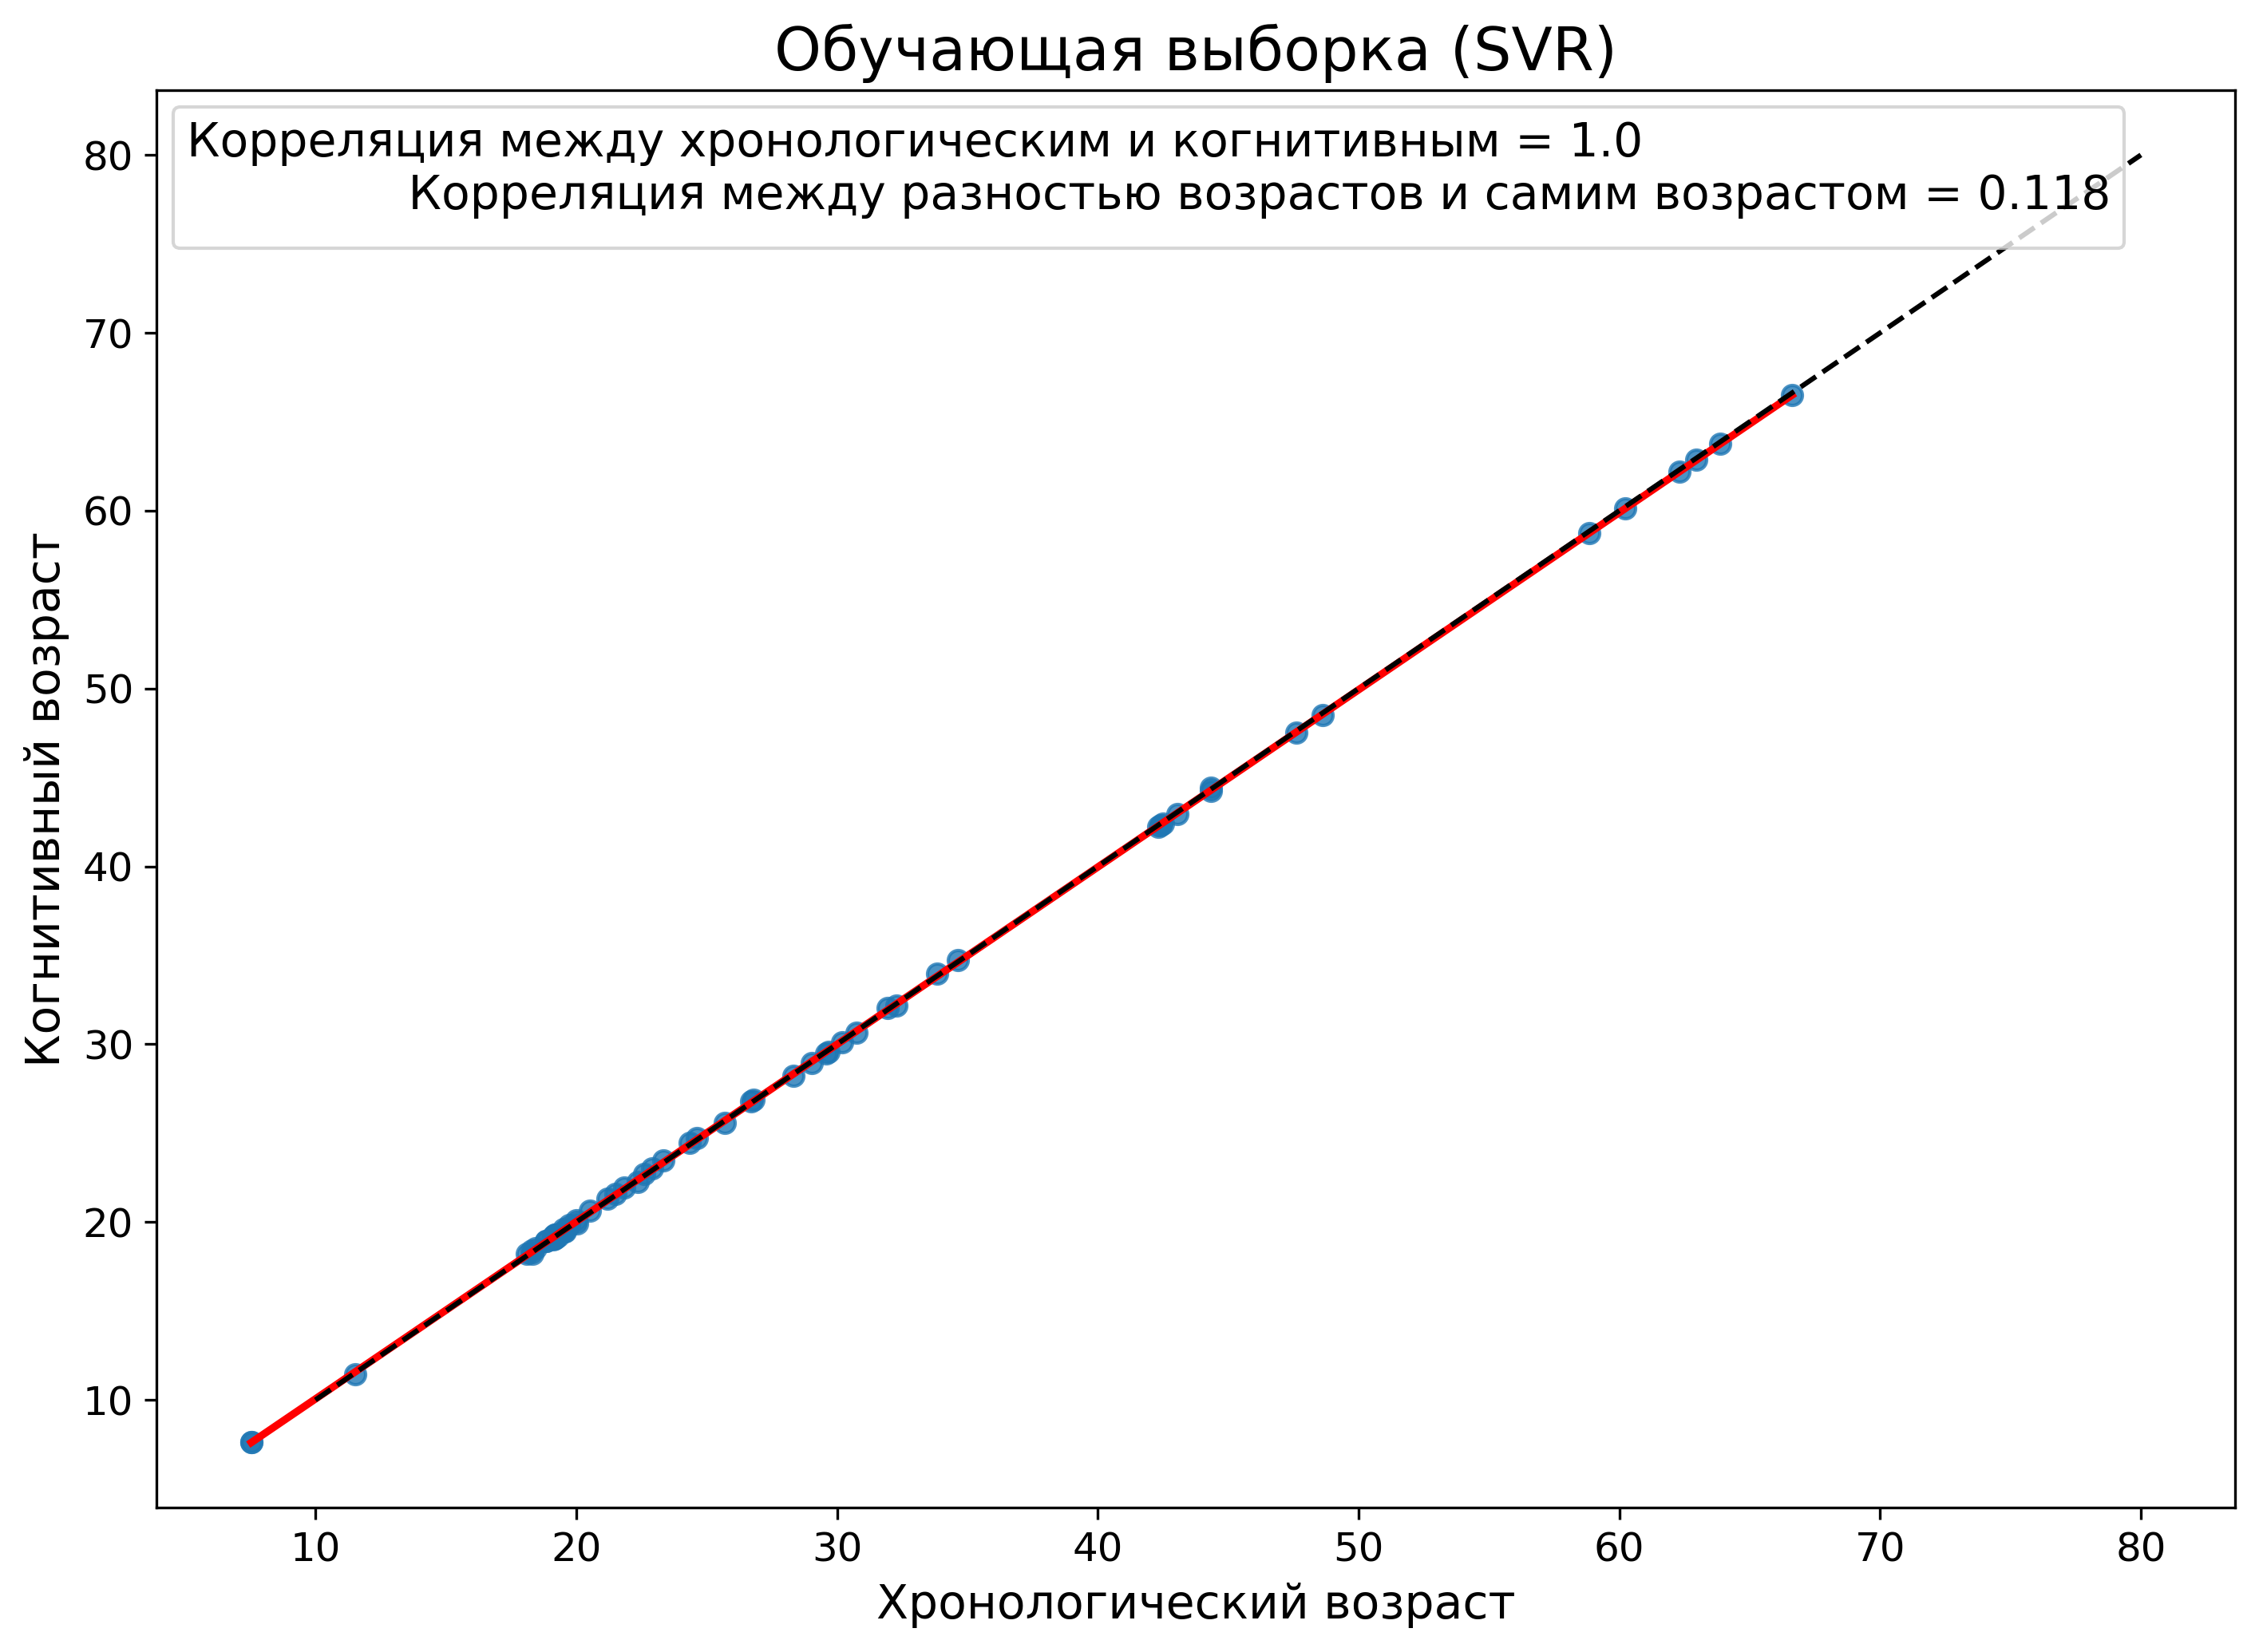

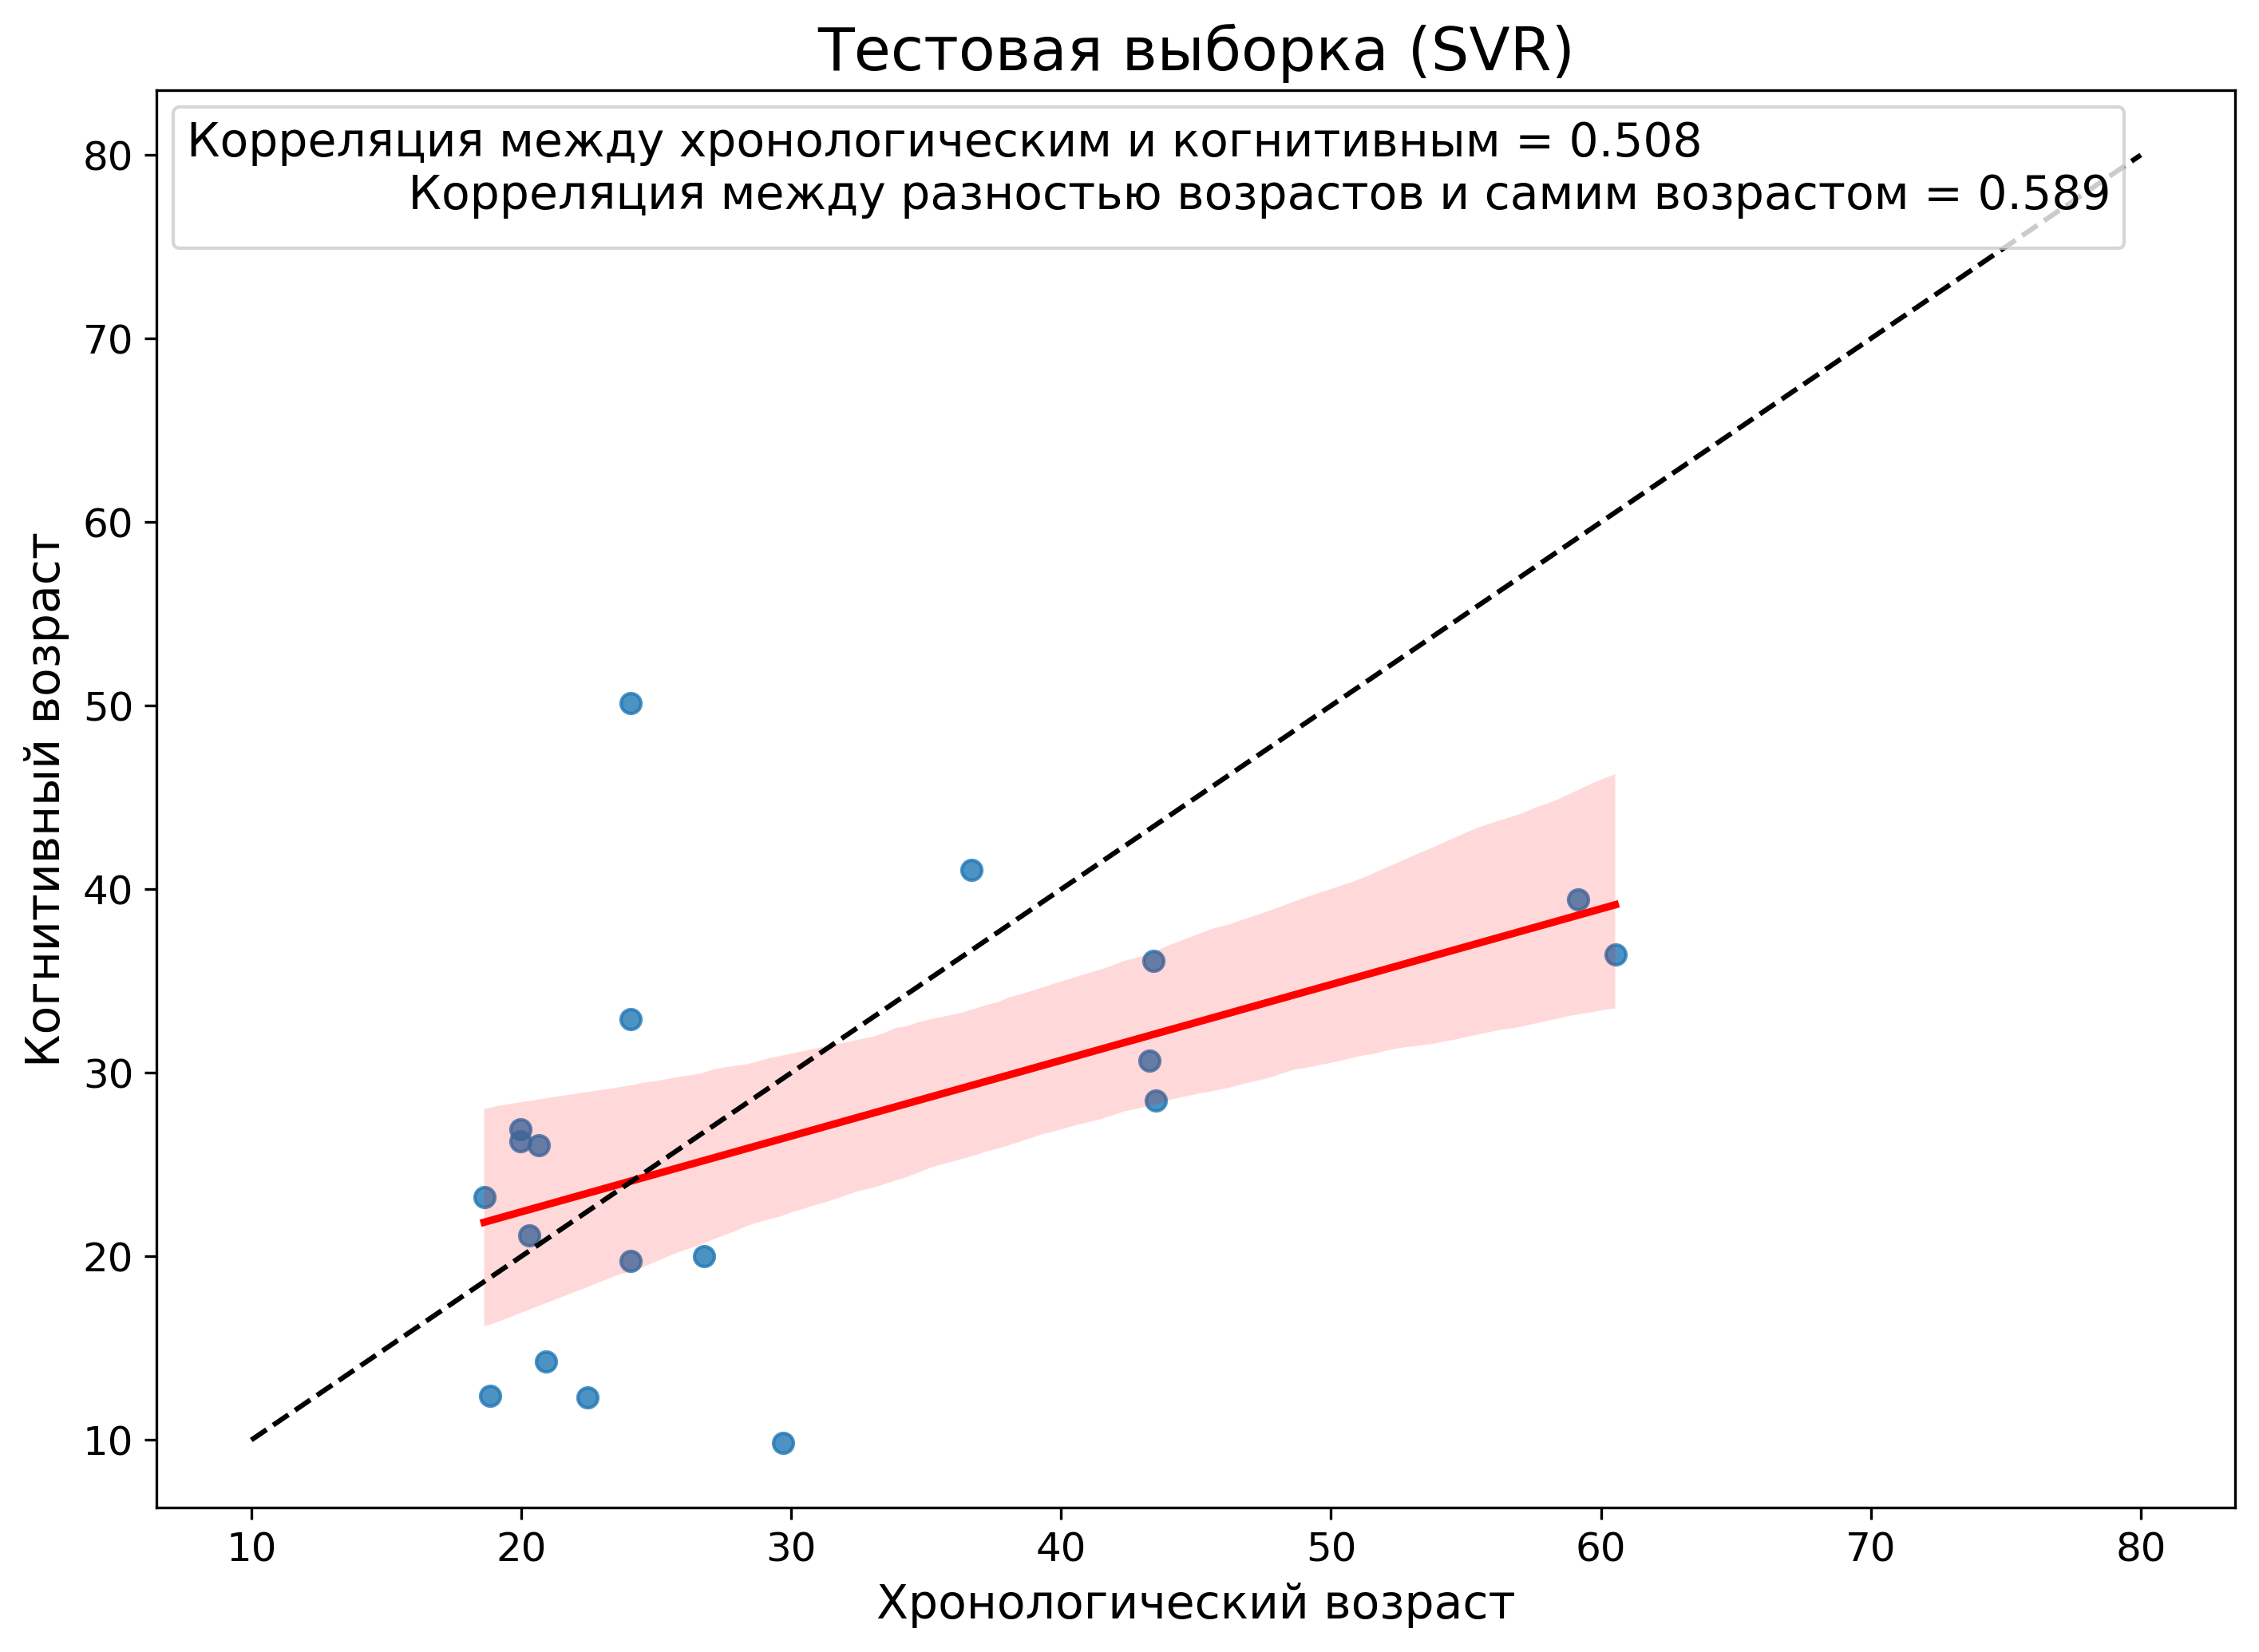

In [5]:
def scatterplot_with_ages(y1, y2, label): 
    ages_df = pd.DataFrame({
        'Хронологический возраст': y1,
        'Когнитивный возраст': y2
    })

    plt.figure(figsize=(10, 7), dpi=300)

    r1, p = pearsonr(y1, y2)
    r2, p = spearmanr(abs(y2 - y1), y1)
    sns.regplot(
        data=ages_df,
        x='Хронологический возраст',
        y='Когнитивный возраст',
        line_kws={'color': 'red'}
    )
    
    plt.legend(title=f'Корреляция между хронологическим и когнитивным = {round(r1, 3)}\n\
               Корреляция между разностью возрастов и самим возрастом = {round(r2, 3)}', loc='upper left', title_fontsize=14)
    # TODO другую корреляцию для |y2 - y1|, y1
    plt.title(label=label, fontsize=18)
    plt.plot([10, 80], [10, 80], 'k--') 
    plt.xlabel('Хронологический возраст', fontsize = 14)
    plt.ylabel('Когнитивный возраст', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


scatterplot_with_ages(y_train, y_train_pred, label='Обучающая выборка (SVR)')
scatterplot_with_ages(y_test, y_test_pred, label='Тестовая выборка (SVR)')